# Trend in horizontal gradient metric

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

from scipy.stats import linregress

import matplotlib.pyplot as plt

import util
import obs_surface
import figure_panels

In [3]:
da_srf = (
        obs_surface.open_surface_co2_data('obs', 'CO2')
    )
da_srf

<xarray.DataArray 'CO2' (time: 255, record: 32)>
array([[365.087 , 365.13  , 365.0911, ..., 364.925 , 364.613 ,      nan],
       [365.0233, 365.1871, 365.0878, ..., 364.9575, 364.6776,      nan],
       [364.9477, 365.042 , 364.9615, ..., 365.09  , 364.9108,      nan],
       ...,
       [408.8532, 408.9975, 408.8587, ..., 408.5017, 408.8434,      nan],
       [     nan,      nan, 408.7141, ...,      nan, 408.949 ,      nan],
       [     nan,      nan, 408.3551, ...,      nan, 408.8221,      nan]])
Coordinates:
  * time         (time) datetime64[ns] 1998-12-15 1999-01-15 ... 2020-02-14
    year_frac    (time) float64 1.999e+03 1.999e+03 ... 2.02e+03 2.02e+03
  * record       (record) object 'SPO_NOAA_insitu_CO2' ... 'CPT_SAWS_insitu_CO2'
    institution  (record) object 'NOAA' 'NOAA' 'SIO_O2' ... 'NOAA' 'LSCE' 'SAWS'
    lat          (record) float64 -89.98 -89.98 -89.98 ... -40.68 -37.8 -34.35
    lon          (record) float64 -24.8 -24.8 -24.8 -24.8 ... 144.7 77.54 18.49
    stncode      (record) object 'SPO' 'SPO' 'SPO' 'SPO' ... 'CGO' 'AMS' 'CPT'
Attributes:
    long_name:  CO$_2$
    units:      ppm

In [4]:
da_srf_a = da_srf - da_srf.sel(record=['SPO_NOAA_insitu_CO2',]).mean('record')
da_srf_a

<xarray.DataArray 'CO2' (time: 255, record: 32)>
array([[ 0.    ,  0.043 ,  0.0041, ..., -0.162 , -0.474 ,     nan],
       [ 0.    ,  0.1638,  0.0645, ..., -0.0658, -0.3457,     nan],
       [ 0.    ,  0.0943,  0.0138, ...,  0.1423, -0.0369,     nan],
       ...,
       [ 0.    ,  0.1443,  0.0055, ..., -0.3515, -0.0098,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])
Coordinates:
  * time         (time) datetime64[ns] 1998-12-15 1999-01-15 ... 2020-02-14
    year_frac    (time) float64 1.999e+03 1.999e+03 ... 2.02e+03 2.02e+03
  * record       (record) object 'SPO_NOAA_insitu_CO2' ... 'CPT_SAWS_insitu_CO2'
    institution  (record) object 'NOAA' 'NOAA' 'SIO_O2' ... 'NOAA' 'LSCE' 'SAWS'
    lat          (record) float64 -89.98 -89.98 -89.98 ... -40.68 -37.8 -34.35
    lon          (record) float64 -24.8 -24.8 -24.8 -24.8 ... 144.7 77.54 18.49
    stncode      (record) object 'SPO' 'SPO' 'SPO' 'SPO' ... 'CGO' 'AMS' 'CPT'

In [5]:
DCO2y_djf = obs_surface.compute_DCO2y(da_srf, 'DJF')
DCO2y_jja = obs_surface.compute_DCO2y(da_srf, 'JJA')
DCO2y_djf

<xarray.Dataset>
Dimensions:      (time: 22)
Coordinates:
  * time         (time) float64 1.999e+03 2e+03 2.001e+03 ... 2.019e+03 2.02e+03
    record       <U19 'SPO_NOAA_insitu_CO2'
    institution  object 'NOAA'
    lat          float64 -89.98
    lon          float64 -24.8
Data variables:
    CO2          (time) float64 -0.09439 -0.179 -0.428 ... -0.3274 -0.2219 nan

In [6]:
ds_djf = util.ann_mean(da_srf_a.to_dataset(), season='DJF', time_bnds_varname=None)
ds_jja = util.ann_mean(da_srf_a.to_dataset(), season='JJA', time_bnds_varname=None)
ds_djf

<xarray.Dataset>
Dimensions:      (record: 32, time: 22)
Coordinates:
  * record       (record) object 'SPO_NOAA_insitu_CO2' ... 'CPT_SAWS_insitu_CO2'
    institution  (record) object 'NOAA' 'NOAA' 'SIO_O2' ... 'NOAA' 'LSCE' 'SAWS'
    lat          (record) float64 -89.98 -89.98 -89.98 ... -40.68 -37.8 -34.35
    lon          (record) float64 -24.8 -24.8 -24.8 -24.8 ... 144.7 77.54 18.49
    stncode      (record) object 'SPO' 'SPO' 'SPO' 'SPO' ... 'CGO' 'AMS' 'CPT'
  * time         (time) int64 1999 2000 2001 2002 2003 ... 2017 2018 2019 2020
Data variables:
    CO2          (time, record) float64 0.0 0.1004 0.02747 ... nan nan nan

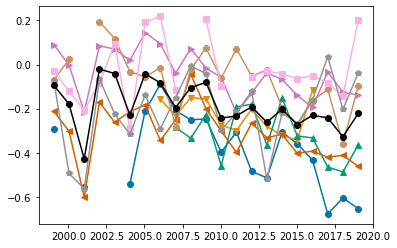

In [7]:
dset_djf = ds_djf.groupby('stncode').mean('record').sel(stncode=obs_surface.southern_ocean_stn_list)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

marker_spec = figure_panels.marker_spec_surface_stations()
x = dset_djf.time + 0.04
for i, stn_code in enumerate(dset_djf.stncode.values):

    y = dset_djf.CO2.sel(stncode=stn_code)
    ax.plot(x, y, linestyle='-', **marker_spec[stn_code])

X = DCO2y_djf.time.values
Y = DCO2y_djf.CO2.values
ax.plot(X, Y, 'ko-')

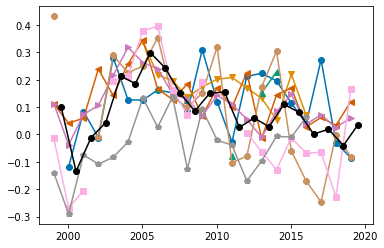

In [8]:
dset_jja = ds_jja.groupby('stncode').mean('record').sel(stncode=obs_surface.southern_ocean_stn_list)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

marker_spec = figure_panels.marker_spec_surface_stations()
x = dset_jja.time + 0.04
for i, stn_code in enumerate(dset_jja.stncode.values):

    y = dset_jja.CO2.sel(stncode=stn_code)
    ax.plot(x, y, linestyle='-', **marker_spec[stn_code])

X = DCO2y_jja.time.values
Y = DCO2y_jja.CO2.values
ax.plot(X, Y, 'ko-')

In [11]:
periods = [
    (1999, 2006),
    (2005, 2020),
    (1999, 2020),    
]

lines = []
for i, period in enumerate(periods):
    dsp = DCO2y_djf.sel(time=slice(period[0], period[1]))
    d = dict(
        year_range=f"{int(dsp.time.values[0])}-{int(dsp.time.values[-1])}",
        delta=dsp.CO2.values[-1] - dsp.CO2.values[0],
    )
    d['slope'], d['intercept'], d['r_value'], d['p_value'], d['stderr'] = linregress(dsp.time,  dsp.CO2)
    lines.append(d)
df_fit_djf = pd.DataFrame(lines).set_index("year_range")
df_fit_djf

,delta,slope,intercept,r_value,p_value,stderr
year_range,,,,,,
1999-2005,0.052332,0.015879,-31.939016,0.235028,0.611932,0.029369
2005-2019,-0.179887,-0.014225,28.425354,-0.780448,0.000597,0.003161
1999-2019,-0.127555,-0.006835,13.545181,-0.412210,0.063331,0.003466


In [12]:
lines = []
for i, period in enumerate(periods):
    dsp = DCO2y_jja.sel(time=slice(period[0], period[1]))
    d = dict(
        year_range=f"{int(dsp.time.values[0])}-{int(dsp.time.values[-1])}",
        delta=dsp.CO2.values[-1] - dsp.CO2.values[0],
    )
    d['slope'], d['intercept'], d['r_value'], d['p_value'], d['stderr'] = (
        linregress(dsp.time,  dsp.CO2)
    )
    lines.append(d)
df_fit_jja = pd.DataFrame(lines).set_index("year_range")
df_fit_jja

,delta,slope,intercept,r_value,p_value,stderr
year_range,,,,,,
1999-2005,0.198383,0.052205,-104.442431,0.764587,0.045284,0.019680
2005-2019,-0.262310,-0.017257,34.823807,-0.831013,0.000124,0.003204
1999-2019,-0.063927,-0.003656,7.432276,-0.222359,0.332654,0.003677
